# TensorFlow powerspectrum

In [1]:
from halotools.sim_manager import CachedHaloCatalog
from halotools.empirical_models import PrebuiltHodModelFactory
from halotools.mock_observables.two_point_clustering import tpcf
from halotools.mock_observables import return_xyz_formatted_array

from tensorflow_probability import edward2 as ed
from diffhod.components import Zheng07Cens, Zheng07SatsRelaxedBernoulli, NFWProfile

from flowpm.utils import cic_paint
import tensorflow as tf
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/francois/repo/DHOD/diffhod/components.py:9: UserWarning: tfp.edward2 module is deprecated and will be removed on 2019-12-01. Use https://github.com/google/edward2 library instead.
  logMmin=ed.Deterministic(11.35, name='logMmin'),


In [2]:
def _initialize_pk(shape,boxsize,kmin,dk):
    """
       Helper function to initialize various (fixed) values for powerspectra... not differentiable!
    """
    I = np.eye(len(shape), dtype='int') * -2 + 1

    W = np.empty(shape, dtype='f4')
    W[...] = 2.0
    W[..., 0] = 1.0
    W[..., -1] = 1.0
    kedges = np.arange(kmin, np.pi * 3 / 2 + dk/2, dk)

    k = [np.fft.fftfreq(N, 1. / (N * 2 * np.pi / L))[:pkshape].reshape(kshape) for N, L, kshape, pkshape in zip(shape.as_list(), boxsize, I, shape.as_list())]
    kmag = sum(ki ** 2 for ki in k) ** 0.5

    xsum = np.zeros(len(kedges) + 1)
    Nsum = np.zeros(len(kedges) + 1)

    dig = np.digitize(kmag.flat, kedges)

    xsum.flat += np.bincount(dig, weights=(W * kmag).flat, minlength=xsum.size)
    Nsum.flat += np.bincount(dig, weights=W.flat, minlength=xsum.size)
    dig = tf.convert_to_tensor(dig,dtype=tf.int32)
    Nsum = tf.convert_to_tensor(Nsum,dtype=tf.complex64)
    xsum = tf.convert_to_tensor(np.array(xsum))
    W = tf.convert_to_tensor(np.array(W))
    k = np.array(k)
    kedges = tf.convert_to_tensor(np.array(kedges))
    return dig, Nsum, xsum, W, k, kedges

In [3]:
def pk(field,kmin=5,dk=0.8,shape = False,boxsize= False):   
    """
    Calculate the powerspectra given real space field
    
    Args:
        
        field: real valued field 
        kmin: minimum k-value for binned powerspectra
        dk: differential in each kbin
        shape: shape of field to calculate field (can be strangely shaped?)
        boxsize: length of each boxlength (can be strangly shaped?)
    
    Returns:
        
        kbins: the central value of the bins for plotting
        power: real valued array of power in each bin
        
    """
    
    #initialze values related to powerspectra
    dig, Nsum, xsum, W, k, kedges = _initialize_pk(shape,boxsize,kmin,dk)
    
    #convert field to complex for fft
    field_complex = tf.dtypes.cast(field,dtype=tf.complex64)

    #fast fourier transform
    fft_image = tf.signal.fft3d(field_complex)
    
    #absolute value of fast fourier transform
    pk = tf.math.real(fft_image*tf.math.conj(fft_image))
    #calculating powerspectra
    Psum = tf.zeros(tf.size(kedges) + 1, dtype=tf.complex64)
    real = tf.reshape(tf.math.real(pk),[-1,])
    imag = tf.reshape(tf.math.imag(pk),[-1,])
    
    Psum  += tf.dtypes.cast(tf.math.bincount(dig, weights=(tf.reshape(W,[-1])  * imag), minlength=tf.size(xsum)),dtype=tf.complex64)*1j
    Psum  += tf.dtypes.cast(tf.math.bincount(dig, weights=(tf.reshape(W,[-1]) * real), minlength=tf.size(xsum)),dtype=tf.complex64)
    #print(W.flatten()  * imag,Psum)

    power = (Psum / Nsum)[1:-1] * boxsize.prod() 
    
    #normalization for powerspectra
    norm = tf.dtypes.cast(tf.reduce_prod(shape),dtype=tf.float32)**2
    
    #find central values of each bin
    kbins = kedges[:-1]+ (kedges[1:] - kedges[:-1])/2
    
    return kbins,tf.dtypes.cast(power,dtype=tf.float32)/norm

In [4]:
# Load a reference halo catalog
halocat = CachedHaloCatalog(simname = 'bolshoi', redshift=0.) 

# Removing subhalos and convert table to tensors
halo_table = halocat.halo_table
halo_table = halo_table[halo_table['halo_pid'] == -1]


tf_halocat = {k: tf.convert_to_tensor(halo_table[k], dtype=tf.float32) for k in halo_table.colnames}

In [5]:
# We first load our reference halotools model
zheng07_model = PrebuiltHodModelFactory('zheng07', redshift =-0, 
                                        modulate_with_cenocc=True)

In [6]:
# Let's see what are the parameters of the model
zheng07_model.param_dict

{'logMmin': 12.02,
 'sigma_logM': 0.26,
 'logM0': 11.38,
 'logM1': 13.31,
 'alpha': 1.06}

In [11]:
# Here is how we define the same model in diffhod
@tf.function
def hod(halo_cat, logMmin, sigma_logM, max_sat=20, temp=0.1):
    
  ### Occupation model ###
  n_cen = Zheng07Cens(halo_cat['halo_mvir'],
                      sigma_logM=sigma_logM,
                      logMmin=logMmin,
                      temperature=temp)
#   n_sat = Zheng07SatsRelaxedBernoulli(halo_cat['halo_mvir'],
#                                       n_cen,
#                                       **zheng07_model.param_dict,
#                                       sample_shape=(max_sat,),
#                                       temperature=temp)
  
  ### Phase Space model ###
  # Centrals are just located at center of halo
  pos_cen = ed.Deterministic(tf.stack([halo_cat['halo_x'],
                                        halo_cat['halo_y'],
                                        halo_cat['halo_z']], axis=-1))

#   # Satellites follow an NFW profile centered on halos
#   pos_sat = NFWProfile(pos=pos_cen,
#                         concentration=halo_cat['halo_nfw_conc'],
#                         Rvir=halo_cat['halo_rvir'],
#                         sample_shape=(max_sat,))
  
  return {'pos_cen':pos_cen,'n_cen':n_cen}# 'pos_sat':pos_sat,  'n_sat':n_sat}

In [12]:
@tf.function
def paint_galaxies(gal_cat, nc=128):
    # Take centrals and rescale them to the boxsize
    sample1 = tf.expand_dims(gal_cat['pos_cen'] / 250. * nc, axis=0)
    weights1 = tf.expand_dims(gal_cat['n_cen'], axis=0)

    # Take sats and rescale them to the boxize
#     sample2 = tf.expand_dims(tf.reshape(gal_cat['pos_sat'], [-1,3]) / 250. * nc, axis=0)
#     weights2 = tf.expand_dims(tf.reshape(gal_cat['n_sat'],[-1]), axis=0)

    # And painting them onto a density field
    rho = cic_paint(tf.zeros((1, nc, nc, nc)), sample1, weights1)
    #rho = cic_paint(rho, sample2, weights2)
    return rho

In [13]:
# sampling galaxies from the model, with given params
@tf.function
def sample(halo_cat, logMmin, sigma_logM):
    return paint_galaxies(hod(halo_cat,logMmin, sigma_logM))

In [14]:
rho = sample(tf_halocat, 12.02, 0.26)

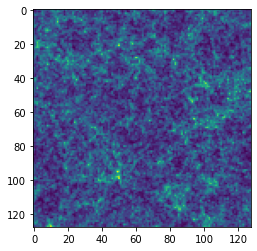

In [16]:
imshow(rho.numpy()[0].sum(axis=0))

In [17]:
k1, pkr1 = pk(rho[0],
         shape=rho[0].shape, 
         boxsize= np.array([128,128,128]), # WARNING: That's not the right size
         kmin=0.001,dk=.05)

<ipython-input-2-5ab92cad888c>:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  kmag = sum(ki ** 2 for ki in k) ** 0.5


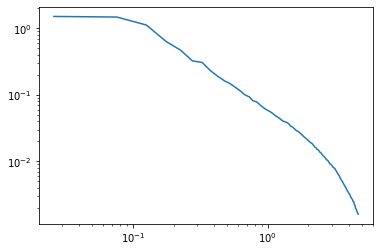

In [18]:
loglog(k1,pkr1)

In [19]:
rho = sample(tf_halocat, 13.02, 0.26)

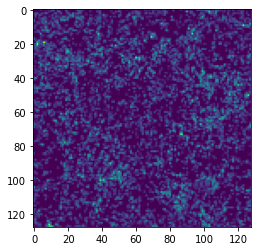

In [20]:
imshow(rho.numpy()[0].sum(axis=0))

In [21]:
k2, pkr2 = pk(sample(tf_halocat, 12.52, 0.26)[0],
         shape=rho[0].shape, 
         boxsize= np.array([128,128,128]), # WARNING: That's not the right size
         kmin=0.001,dk=.05)

<ipython-input-2-5ab92cad888c>:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  kmag = sum(ki ** 2 for ki in k) ** 0.5


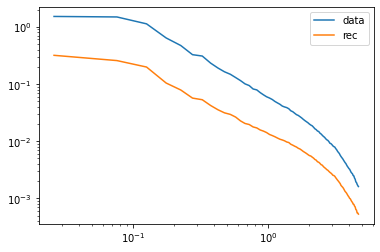

In [189]:
loglog(k1,pkr1, label='data')
loglog(k2,pkr2, label='rec')
legend()

In [23]:
# Ok sweet, so now we can define these as a function of variables
logM = tf.Variable(12.5)
sig_logM = tf.Variable(0.5)

In [24]:
learning_rate=0.005

@tf.function
def opt_step(tf_halocat, pkref):
    with tf.GradientTape() as tape:
        _, pkr = pk(sample(tf_halocat, logM, sig_logM)[0],
             shape=rho[0].shape, 
             boxsize= np.array([128,128,128]), # WARNING: That's not the right size
             kmin=0.001,dk=.05)
        loss = tf.reduce_sum((pkr - pkref)**2)

    grads = tape.gradient(loss, [logM, sig_logM])

    logM.assign_sub(learning_rate*grads[0]);
    sig_logM.assign_sub(learning_rate*grads[1]);
    return loss

for i in range(7):
    loss = opt_step(tf_halocat, pkr1)
    print('loss', loss.numpy())

loss 3.8812966
loss 3.2551785
loss 2.6557617
loss 1.720593
loss 0.70941585
loss 0.19683176
loss 0.02232863


<ipython-input-2-5ab92cad888c>:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  kmag = sum(ki ** 2 for ki in k) ** 0.5


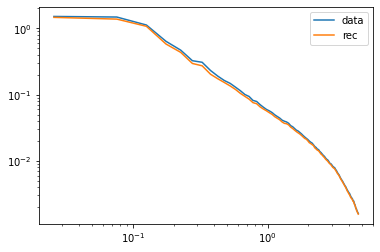

In [25]:
_, pkr = pk(sample(tf_halocat, logM, sig_logM)[0],
     shape=rho[0].shape, 
     boxsize= np.array([128,128,128]), # WARNING: That's not the right size
     kmin=0.001,dk=.05)

loglog(k1,pkr1, label='data')
loglog(k2,pkr, label='rec')
legend()

## Let's try to the same thing but with VI now

In [26]:
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

In [190]:
data = pkr1.numpy()

In [226]:
# Gaussian posterior
# q = tfd.MultivariateNormalTriL(
#     loc=tf.Variable([13.5, 0.5], name="mu"),
#     scale_tril=tfp.util.TransformedVariable(
#         0.1*tf.eye(2, dtype=tf.float32),
#         tfp.bijectors.ScaleTriL(diag_bijector=tfb.Softplus()),
#         name="raw_scale_tril"))
q = tfd.MultivariateNormalDiag(
    loc=tf.Variable([13.0, 0.8], name="mu"),
    scale_diag=tfp.util.TransformedVariable([0.25, 0.05], 
                                            bijector=tfb.Softplus(),
                                            name="scale"))

# And let's also add an independent prior
p = tfd.MultivariateNormalDiag(loc=[12.5, 0.4], scale_diag=[1.5,0.1])

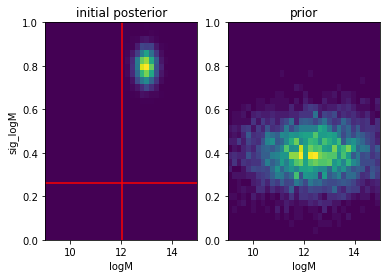

In [227]:
subplot(121)
s = q.sample(5000).numpy()
hist2d(s[:,0], s[:,1],32,range=[[9,15],[0,1]])
axvline(12.02,color='red')
axhline(0.26,color='red')
xlabel('logM')
ylabel('sig_logM')
title('initial posterior')

subplot(122)
s = p.sample(5000).numpy()
hist2d(s[:,0], s[:,1],32,range=[[9,15],[0,1]]);
xlabel('logM')


title('prior');

In [228]:
opt = tf.keras.optimizers.Adam(learning_rate=0.01)

@tf.function
def loss_fn():
    # First we sample from posterior
    z = q.sample()
    
    # We compute associated log lik
    _, pkr = pk(sample(tf_halocat, z[0], z[1])[0],
     shape=rho[0].shape, 
     boxsize= np.array([128,128,128]), # WARNING: That's not the right size
     kmin=0.001,dk=.05)
    
    log_lik = tf.reduce_sum((pkr - data)**2)
    
    # And here we compute the KL divergence
    kl = tf.clip_by_value(q.log_prob(z) - p.log_prob(z), 0, 1000)
    
    return log_lik*10  + kl

In [229]:
print(q.mean())

tf.Tensor([13.   0.8], shape=(2,), dtype=float32)


In [230]:
loss_fn()

<tf.Tensor: shape=(), dtype=float32, numpy=72.31191>

In [ ]:
for i in range(100):
    opt.minimize(loss_fn,  q.trainable_variables)
    print(q.mean())

tf.Tensor([12.623424   0.7782686], shape=(2,), dtype=float32)
tf.Tensor([12.612616   0.7832668], shape=(2,), dtype=float32)
tf.Tensor([12.601287   0.7897872], shape=(2,), dtype=float32)


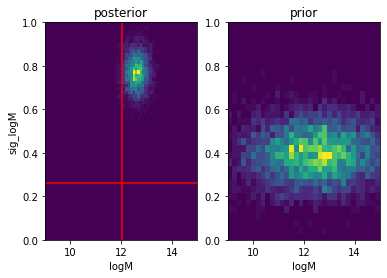

In [236]:
#Well.... it's moving...
subplot(121)
s = q.sample(5000).numpy()
hist2d(s[:,0], s[:,1],64,range=[[9,15],[0,1]])
axvline(12.02,color='red')
axhline(0.26,color='red')
xlabel('logM')
ylabel('sig_logM')
title('posterior')

subplot(122)
s = p.sample(5000).numpy()
hist2d(s[:,0], s[:,1],32,range=[[9,15],[0,1]]);
xlabel('logM')

title('prior');

tf.Tensor([12.420755   0.7162155], shape=(2,), dtype=float32)


<ipython-input-2-5ab92cad888c>:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  kmag = sum(ki ** 2 for ki in k) ** 0.5


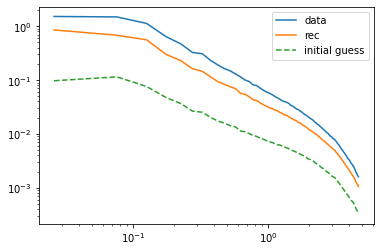

In [237]:
# Let's have a look at a sample from the posterior
z = q.sample()
print(z)
_, pkr = pk(sample(tf_halocat, z[0], z[1])[0],
     shape=rho[0].shape, 
     boxsize= np.array([128,128,128]), # WARNING: That's not the right size
     kmin=0.001,dk=.05)

_, pk0 = pk(sample(tf_halocat, 13, 0.8)[0],
     shape=rho[0].shape, 
     boxsize= np.array([128,128,128]), # WARNING: That's not the right size
     kmin=0.001,dk=.05)



loglog(k1,pkr1, label='data')
loglog(k2,pkr, label='rec')
loglog(k2,pk0, '--', label='initial guess')
legend()

In [234]:
q

<tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=[] event_shape=[2] dtype=float32>